# Import Libraries

In [129]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Read Dataset

In [130]:
#Read datasets
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')
#Read test datasets
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# Fix metric on ceiling_height_agl:m and cloud_base_agl:m

Found that most likely the **ceiling_height_agl:m** and **cloud_base_agl:m** starts with values in meters, and then suddenly switches into using feet at 26.03.2020. Therefore I transform the values before 26.03.2020 into feet. 

In [131]:
mask_a = X_train_observed_a['date_forecast'] < '2020-03-26'
mask_b = X_train_observed_b['date_forecast'] < '2020-03-26'
mask_c = X_train_observed_c['date_forecast'] < '2020-03-26'

# Apply the conversion from meters to feet (1 meter = 3.28084 feet)
conversion_factor = 3.28084

X_train_observed_a.loc[mask_a, 'ceiling_height_agl:m'] *= conversion_factor
X_train_observed_b.loc[mask_b, 'ceiling_height_agl:m'] *= conversion_factor
X_train_observed_c.loc[mask_c, 'ceiling_height_agl:m'] *= conversion_factor

X_train_observed_a.loc[mask_a, 'cloud_base_agl:m'] *= conversion_factor
X_train_observed_b.loc[mask_b, 'cloud_base_agl:m'] *= conversion_factor
X_train_observed_c.loc[mask_c, 'cloud_base_agl:m'] *= conversion_factor

As the features have a 0.83 correlation, I choose to go forward with ceiling height

# Concat data and split into timeframes

In [132]:

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"
X_test_estimated_a["location"] = "A"
X_test_estimated_b["location"] = "B"
X_test_estimated_c["location"] = "C"

#copy 23:45 value to 00:00 as it isn't there
def fill_last(frame):
    copy = frame.copy()
    
    copy["date_forecast"] = copy["date_forecast"] + pd.Timedelta(minutes=15)
    
    copy = copy[copy["date_forecast"].apply(lambda time : time.hour == 0 and time.minute == 0)]
    
    frame = pd.concat([
        frame,
        copy
    ])
    return frame.drop_duplicates(subset="date_forecast", keep="first")

#fill last
X_test_estimated_a = fill_last(X_test_estimated_a)
X_test_estimated_b = fill_last(X_test_estimated_b)
X_test_estimated_c = fill_last(X_test_estimated_c)

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c,
                     X_test_estimated_a,
                     X_test_estimated_b,
                     X_test_estimated_c])

#fix ceiling_height NaN values to -666 because the docs hints to it
#also rename the features with their proper metric and remove the old ones
X_train_raw["ceiling_height_agl:ft"] = X_train_raw["ceiling_height_agl:m"].fillna(-666)
X_train_raw["cloud_base_agl:ft"] = X_train_raw["cloud_base_agl:m"].fillna(-666)
X_train_raw.drop(columns=["ceiling_height_agl:m", "cloud_base_agl:m"], inplace=True)

#categorizing ceiling_height_agl:ft
X_train_raw['ceiling_height_agl:ft'] = pd.cut(X_train_raw['ceiling_height_agl:ft'], bins=[-1000, 0, 500, 1000, 3000, 5000, 12000, float('inf')], labels=[-666, 1, 2, 3, 4, 5, 6])
X_train_raw.drop(columns=["cloud_base_agl:ft"], inplace=True)

"""
#categorizing precip_type_5min:idx
#found this in the docs
precip_types = {
    0: "None",
    1: "Rain",
    2: "Rain_and_snow_mixed",
    3: "Snow",
    4: "Freezing_rain",
    5: "Hail",
}
#map the values to their labels
X_train_raw['precip_type_5min:idx'] = X_train_raw['precip_type_5min:idx'].map(precip_types)
"""

#remove some weird artifacts from train_b target values
train_b = pd.concat([train_b[:18690], train_b[20142:]])
train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
train_b = train_b[train_b["keep"]]
train_b = train_b.iloc[:,:3]

parse_dates = ['time']
X_test_targets = pd.read_csv("test.csv", parse_dates=parse_dates)
display(X_test_targets)

train_a["id"] = -10
train_b["id"] = -10
train_c["id"] = -10

X_test_targets = X_test_targets.rename(columns = {"prediction" : "pv_measurement"})

targets = pd.concat([train_a,
                     train_b,
                     train_c,
                     X_test_targets]).dropna()

features00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].copy()
features00["merge_time"] = features00["date_forecast"]


features15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].copy()
features15["merge_time"] = features15["date_forecast"] + pd.Timedelta(minutes=-15)


features30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].copy()
features30["merge_time"] = features30["date_forecast"] + pd.Timedelta(minutes=-30)


features45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].copy()
features45["merge_time"] = features45["date_forecast"] + pd.Timedelta(minutes=-45)


X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes = -60)
features60 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 00)].copy()
features60["merge_time"] = features60["date_forecast"]

dataset = targets
dataset = dataset.rename(columns={"time": "merge_time"})

display(X_train_raw)

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location,ceiling_height_agl:ft
0,2019-06-02 22:00:00,2019-06-02 21:00:00,7.7,1.230,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,98.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.799988,0.0,0.0,994.200012,1000.299988,0.0,0.0,73.099998,1006.299988,NaN,0.0,0.0,-0.0,0.1,342.834015,-3.202,0.0,285.899994,100.000000,39640.101562,3.7,-3.6,-0.8,-0.0,A,5
1,2019-06-02 22:15:00,2019-06-02 21:15:00,7.7,1.229,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.500000,0.0,0.0,993.900024,999.900024,0.0,0.0,72.199997,1006.000000,NaN,0.0,0.0,-0.0,0.2,346.294006,-3.650,0.0,286.100006,100.000000,40123.898438,3.6,-3.6,-0.6,-0.0,A,5
2,2019-06-02 22:30:00,2019-06-02 21:30:00,7.7,1.228,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.199997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.099976,0.0,0.0,993.599976,999.599976,0.0,0.0,71.199997,1005.599976,NaN,0.0,0.0,-0.0,0.2,349.768005,-3.998,0.0,286.299988,100.000000,40628.300781,3.6,-3.6,-0.4,-0.0,A,5
3,2019-06-02 22:45:00,2019-06-02 21:45:00,7.7,1.226,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.400002,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.799988,0.0,0.0,993.299988,999.299988,0.0,0.0,70.199997,1005.299988,NaN,0.0,0.0,-0.0,0.2,353.251007,-4.247,0.0,286.600006,100.000000,41153.601562,3.5,-3.5,-0.2,-0.0,A,5
4,2019-06-02 23:00:00,2019-06-02 22:00:00,7.7,1.225,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.500000,0.0,0.0,993.000000,999.000000,0.0,0.0,69.199997,1005.000000,NaN,0.0,0.0,-0.0,0.2,356.742004,-4.393,0.0,286.799988,100.000000,41699.898438,3.5,-3.5,0.0,-0.0,A,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,2023-06-18 07:00:05,2023-06-19 23:00:00,10.7,1.193,0.0,0.0,0.0,285.600006,0.0,0.0,0.0,0.0,27.799999,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1011.000000,0.0,0.0,995.299988,1001.200012,0.0,0.0,59.200001,1007.000000,NaN,0.0,0.0,-0.0,0.0,6.356000,-3.011,0.0,293.700012,43.500000,46996.800781,4.0,-2.0,3.5,-0.0,C,5
2303,2023-06-21 07:00:30,2023-06-22 23:00:00,9.4,1.228,0.0,0.0,0.0,283.299988,0.0,0.0,0.0,0.0,95.599998,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.900024,0.0,0.0,997.799988,1003.799988,0.0,0.0,83.199997,1009.900024,NaN,0.0,0.0,-0.0,0.0,6.206000,-2.996,0.0,285.399994,96.800003,33542.898438,1.3,-0.6,1.1,-0.0,C,3
2399,2023-06-25 07:01:23,2023-06-26 23:00:00,9.8,1.187,0.0,0.0,0.0,284.200012,0.0,0.0,0.0,0.0,2.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.799988,0.0,0.0,989.200012,995.000000,0.0,0.0,53.099998,1000.799988,NaN,0.0,0.0,-0.0,0.0,6.015000,-3.071,0.0,295.500000,2.000000,48980.699219,3.1,-2.0,2.5,-0.0,C,-666
2687,2023-06-29 07:00:05,2023-06-30 23:00:00,9.3,1.220,0.0,0.0,0.0,283.100006,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.000000,0.0,0.0,989.200012,995.200012,0.0,0.1,88.800003,1001.200012,NaN,0.0,0.0,-0.0,0.2,5.837000,-3.254,0.1,284.399994,100.000000,9935.700195,1.8,1.6,-0.9,0.0,C,3


# Define helper functions

In [133]:
#averages the features meassured at target time +00, +15, +30, +45 and +60
def add_feature_average_00_60(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = pd.merge(
        left=dataset,
        right = f00[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")
    dataset = pd.merge(
        left=dataset,
        right = f15[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_15"])
    dataset = pd.merge(
        left=dataset,
        right = f30[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_30"])
    dataset = pd.merge(
        left=dataset,
        right = f45[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_45"])
    dataset = pd.merge(
        left=dataset,
        right = f60[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_60"])


    dataset[column_name] = (dataset[column_name] +
                            dataset[column_name + "_15"] +
                            dataset[column_name + "_30"] +
                            dataset[column_name + "_45"] +
                            dataset[column_name + "_60"])/5
    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

#adds a single feature from one observation
def add_feature(dataset, f, column_name):
  return pd.merge(
        left=dataset,
        right=f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner"
  )

#adds an One Hot Encoding of the column to the dataset
def OHE(dataset, f, column_name, suffix=""):

    dataset = pd.merge(
        left=dataset,
        right = f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")

    values = dataset[column_name].unique()

    for value in values:
        dataset[column_name + "_" + suffix + str(value)] = dataset[column_name].apply(lambda a : a == value).map({True: 1, False: 0})

    dataset = dataset.drop([column_name], axis=1)
    return dataset

def OHE_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = OHE(dataset, f00, column_name, suffix="00_")
    dataset = OHE(dataset, f15, column_name, suffix="15_")
    dataset = OHE(dataset, f30, column_name, suffix="30_")
    dataset = OHE(dataset, f45, column_name, suffix="45_")
    dataset = OHE(dataset, f60, column_name, suffix="60_")

    return dataset

#adds all observations
def add_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset[column_name + "_00"] = add_feature(dataset, f00, column_name)[column_name]
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    return dataset

#finds mode (typetall) for a row
def find_mode_with_priority(row, priority_list, max=False):
    # Check for prioritized values in the row and set it as the mode if it is
    for value in priority_list:
        if value in row.values:
            return value

    # Calculate the mode for the row
    if max:
        mode_value = row.mode().max()
    else:
        mode_value = row.mode().min()

    return mode_value

def add_most_frequent_feature(dataset, f15, f30, f45, f60, column_name, priority_list, max=False):
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    feature_names = [column_name + "_15", column_name + "_30", column_name + "_45", column_name + "_60"]

    dataset[column_name] = dataset[feature_names].apply(find_mode_with_priority, args=(priority_list, max), axis=1)

    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

def add_accumulated(dataset, f15, f30, f45, f60, column_name, time_interval):
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    time_multiplier = 15/time_interval

    feature_names = [column_name + "_15", column_name + "_30", column_name + "_45", column_name + "_60"]

    dataset[column_name] = dataset[feature_names].sum(axis=1)*time_multiplier

    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

# Feature info

### Features removed because of correlations:

- **fresh_snow_12h:cm**: fresh_snow_24h:cm = **0.82**

- **fresh_snow_3h:cm**: fresh_snow_1h:cm = **0.81**

- **fresh_snow_6h:cm**: fresh_snow_24h:cm = **0.83**

- **diffuse_rad:W**: diffuse_rad_1h:J = **0.99**

- **direct_rad:W**: direct_rad_1h:J = **0.99**

- **pressure_100m:hPa**: msl_pressure:hPa = **1.00**

- **pressure_50m:hPa**: msl_pressure:hPa = **1.00**

- **sfc_pressure:hPa**: msl_pressure:hPa = **1.00**

- **absolute_humidity_2m:gm3**: t1000:hPa = **0.90**

- **air_density_2m:kgm3**: t1000:hPa = **0.90**

- **dew_point_2m:K**: t1000:hPa = **0.91**

- **clear_sky_rad:W**: sun_elevation = **0.83**

- **clear_sky_energy_1h:J**: sun_elevation = **0.82**

- **total_cloud_cover:p**: effective_cloud_cover:p = **0.94**

- **cloud_base_agl:m**: ceiling_height_agl:m = **0.83** (after recalculating to feet)

### High correlations still in the set:

- **is_day:idx**: sun_elevation = **0.81**

- **diffuse_rad_1h:J**: sun_elevation = **0.80**

### Other features removed:

- **snow_drift:idx**: Almost exclusively 0, so doesn't add much data

- **wind_speed_w_1000hPa:ms**: In relation to the dummy data found in the docs this data is really weird (binary as opposed to continous values)


# Add standardizable features

In [134]:
# SNOW AND PRECIPITATION

# tar verdi fra +60 siden den viser måling mellom 00 og 60, #!kan det være gunstig å ha med 3h, 6h, 12h????
dataset = add_feature(dataset, features60, "fresh_snow_1h:cm")
dataset = add_feature(dataset, features60, "fresh_snow_24h:cm")
# tar akkumulert verdi og ganger med 3 for å få en bedre verdi (ikke helt etter boka menmen...)
dataset = add_accumulated(dataset, features15, features30, features45, features60, "precip_5min:mm", 5)
# disse tar jeg bare gjennomsnittet av
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_depth:cm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_water:kgm2")
# tar akkumulert verdi og ganger med 3/2 for å få en bedre verdi (ikke helt etter boka menmen...)
dataset = add_accumulated(dataset, features15, features30, features45, features60, "snow_melt_10min:mm", 10)


# ACCUMULATIVE FEATURES

# tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "diffuse_rad_1h:J")
# tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "direct_rad_1h:J")#!Try without


# PRESSURE

# tar gjennomsnittet da dette er punktmålinger ##kan hende denne burde kjøres per kvarter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "msl_pressure:hPa")


# TEMPERATURE

# gjennomsnitt siden variasjonen hvert kvarter sannsynligvis er lav? ##kan hende denne burde kjøres per kvarter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "t_1000hPa:K")


# SUN

#legger til alle siden har testing har vist at disse er svært viktige
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_azimuth:d")
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_elevation:d")


# DAY AND SHADOW

#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "visibility:m")


# CLOUDS

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "effective_cloud_cover:p")


# HUMIDITY AND RIME

#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "prob_rime:p")
#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "relative_humidity_1000hPa:p")


# WIND

# Gjennomsnitt fordi lite variabel
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_u_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_v_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_10m:ms")


# OTHERS (Up for discussion)

# Legger til 1 verdi fordi alle er like
dataset = add_feature(dataset, features60, "elevation:m")
# Gjennomsnitt fordi?
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "super_cooled_liquid_water:kgm2")

display(dataset)

,merge_time,pv_measurement,location,id,fresh_snow_1h:cm,fresh_snow_24h:cm,precip_5min:mm,snow_depth:cm,snow_water:kgm2,snow_melt_10min:mm,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,visibility:m,effective_cloud_cover:p,prob_rime:p,relative_humidity_1000hPa:p,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_10m:ms,elevation:m,super_cooled_liquid_water:kgm2
0,2019-06-02 22:00:00,0.00,A,-10,0.0,0.0,0.0,0.0,0.18,0.0,0.000000,0.000000,1006.140015,286.339996,342.834015,346.294006,349.768005,353.251007,356.742004,-3.202,-3.650,-3.998,-4.247,-4.393,0.0,0.0,0.0,0.0,0.0,40649.164062,99.180000,0.0,71.179993,-3.56,-0.40,3.58,6.0,0.00
1,2019-06-02 23:00:00,0.00,A,-10,0.0,0.0,0.0,0.0,0.20,0.0,0.000000,0.000000,1005.079956,286.919983,356.742004,0.235000,3.728000,7.218000,9.741000,-4.393,-4.438,-4.379,-4.219,-3.910,0.0,0.0,0.0,0.0,0.0,31111.119141,99.799995,0.0,67.599998,-3.30,0.36,3.32,6.0,0.00
2,2019-06-03 00:00:00,0.00,A,-10,0.0,0.0,0.0,0.0,0.46,0.0,0.000000,0.000000,1004.500000,286.940002,9.741000,13.212000,16.671000,20.115000,23.541000,-3.910,-3.575,-3.142,-2.611,-1.986,0.0,0.0,0.0,0.0,0.0,11297.320312,100.000000,0.0,68.580002,-2.90,0.76,3.00,6.0,0.00
3,2019-06-03 01:00:00,0.00,A,-10,0.0,0.0,0.0,0.0,0.50,0.0,7743.299805,0.000000,1003.900024,286.700012,23.541000,26.948000,30.334000,33.698002,37.040001,-1.986,-1.269,-0.463,0.428,1.401,0.0,0.0,0.0,1.0,1.0,2393.800049,100.000000,0.0,74.800003,-2.58,0.90,2.72,6.0,0.00
4,2019-06-03 02:00:00,19.36,A,-10,0.0,0.0,0.0,0.0,0.22,0.0,60137.601562,3158.300049,1003.000000,286.440002,37.040001,40.359001,43.657001,46.933998,50.193001,1.401,2.453,3.578,4.773,6.033,1.0,1.0,1.0,1.0,1.0,14631.379883,79.659996,0.0,80.419998,-2.32,0.92,2.50,6.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90957,2023-07-03 19:00:00,0.00,C,2155,0.0,0.0,0.0,0.0,0.00,0.0,109878.000000,39874.800781,992.220032,286.799988,301.864990,305.072998,308.291992,311.526001,314.777008,10.182,8.778,7.428,6.136,4.908,1.0,1.0,1.0,1.0,1.0,40833.617188,86.860001,0.0,71.999992,1.90,-1.04,2.16,24.0,0.08
90958,2023-07-03 20:00:00,0.00,C,2156,0.0,0.0,0.0,0.0,0.00,0.0,44498.898438,10678.299805,992.619995,286.380005,314.777008,318.046997,321.338013,324.649994,327.984009,4.908,3.747,2.658,1.645,0.711,1.0,1.0,1.0,1.0,1.0,41705.980469,76.220009,0.0,75.959999,2.04,-0.94,2.24,24.0,0.00
90959,2023-07-03 21:00:00,0.00,C,2157,0.0,0.0,0.0,0.0,0.00,0.0,8968.599609,0.000000,993.000000,285.880005,327.984009,331.338989,334.714996,338.110992,341.524994,0.711,-0.139,-0.903,-1.577,-2.157,1.0,0.0,0.0,0.0,0.0,41136.300781,83.639999,0.0,81.060005,2.00,-0.92,2.20,24.0,0.00
90960,2023-07-03 22:00:00,0.00,C,2158,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,993.320007,285.399994,341.524994,344.954987,348.398010,351.852997,355.315002,-2.157,-2.643,-3.031,-3.320,-3.508,0.0,0.0,0.0,0.0,0.0,39011.281250,100.000000,0.0,83.860001,1.68,-0.76,1.84,24.0,0.08


# Standardize data

In [135]:
# make trig transform on solar angles
def apply_trig(dataset, feature_name, suffixes):
    for suffix in suffixes:
        column_name = f"{feature_name}_{suffix}"
        if column_name in dataset:
            dataset[column_name] = dataset[column_name].apply(lambda d: np.cos((d * np.pi) / 180))

# apply trig transform on solar angles
suffixes = ['00', '15', '30', '45', '60']
apply_trig(dataset, 'sun_azimuth:d', suffixes)
apply_trig(dataset, 'sun_elevation:d', suffixes)

# all features except pv_measurement, merge_time, location and id
columns_to_exclude = ['merge_time', 'pv_measurement', 'location', 'id']
# standardize the features
scaler = StandardScaler()
scaled_columns = scaler.fit_transform(dataset.drop(columns=columns_to_exclude))
scaled_dataset = pd.DataFrame(scaled_columns, columns=dataset.drop(columns=columns_to_exclude).columns)

scaled_dataset[columns_to_exclude] = dataset[columns_to_exclude]

dataset = scaled_dataset


# Add non-standardizable features

In [136]:
# reason I'm adding it here is to prevent the massive -666 value getting in the way of the scaling
# add most frequent bc don't wanna have 100 000 features, also don't add priority list and pick the min value if conflict
dataset = add_most_frequent_feature(dataset, features00, features15, features30, features45, "ceiling_height_agl:ft", priority_list=[], max=False)

# add most frequent bc don't wanna have 100 000 features
dataset = add_most_frequent_feature(dataset, features15, features30, features45, features60, "precip_type_5min:idx", priority_list=[3,4], max=True)

# OHE because value is binary
dataset = OHE(dataset, features60, "snow_density:kgm3")

# OHE av kategorisk variabel #!Opp til diskusjon om man skal ta gjennomsnitt eller flere av målingene
dataset = OHE(dataset, features60, "dew_or_rime:idx")

# tar alle verdiene siden disse nok er ekstremt viktige for modellen og gir ikke mening å standardisere
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_day:idx")

# Adding the hour because it's a cyclic feature and I think it has a lot to say
dataset['hour'] = dataset['merge_time'].dt.hour

# OHE of location
dataset["location_A"] = dataset["location"].apply(lambda loc: loc == "A").map({True: 1, False: 0})
dataset["location_B"] = dataset["location"].apply(lambda loc: loc == "B").map({True: 1, False: 0})
dataset["location_C"] = dataset["location"].apply(lambda loc: loc == "C").map({True: 1, False: 0})

## Current features:

In [137]:
current_features = dataset.columns[3:]
len(current_features)

46

# Show correlations

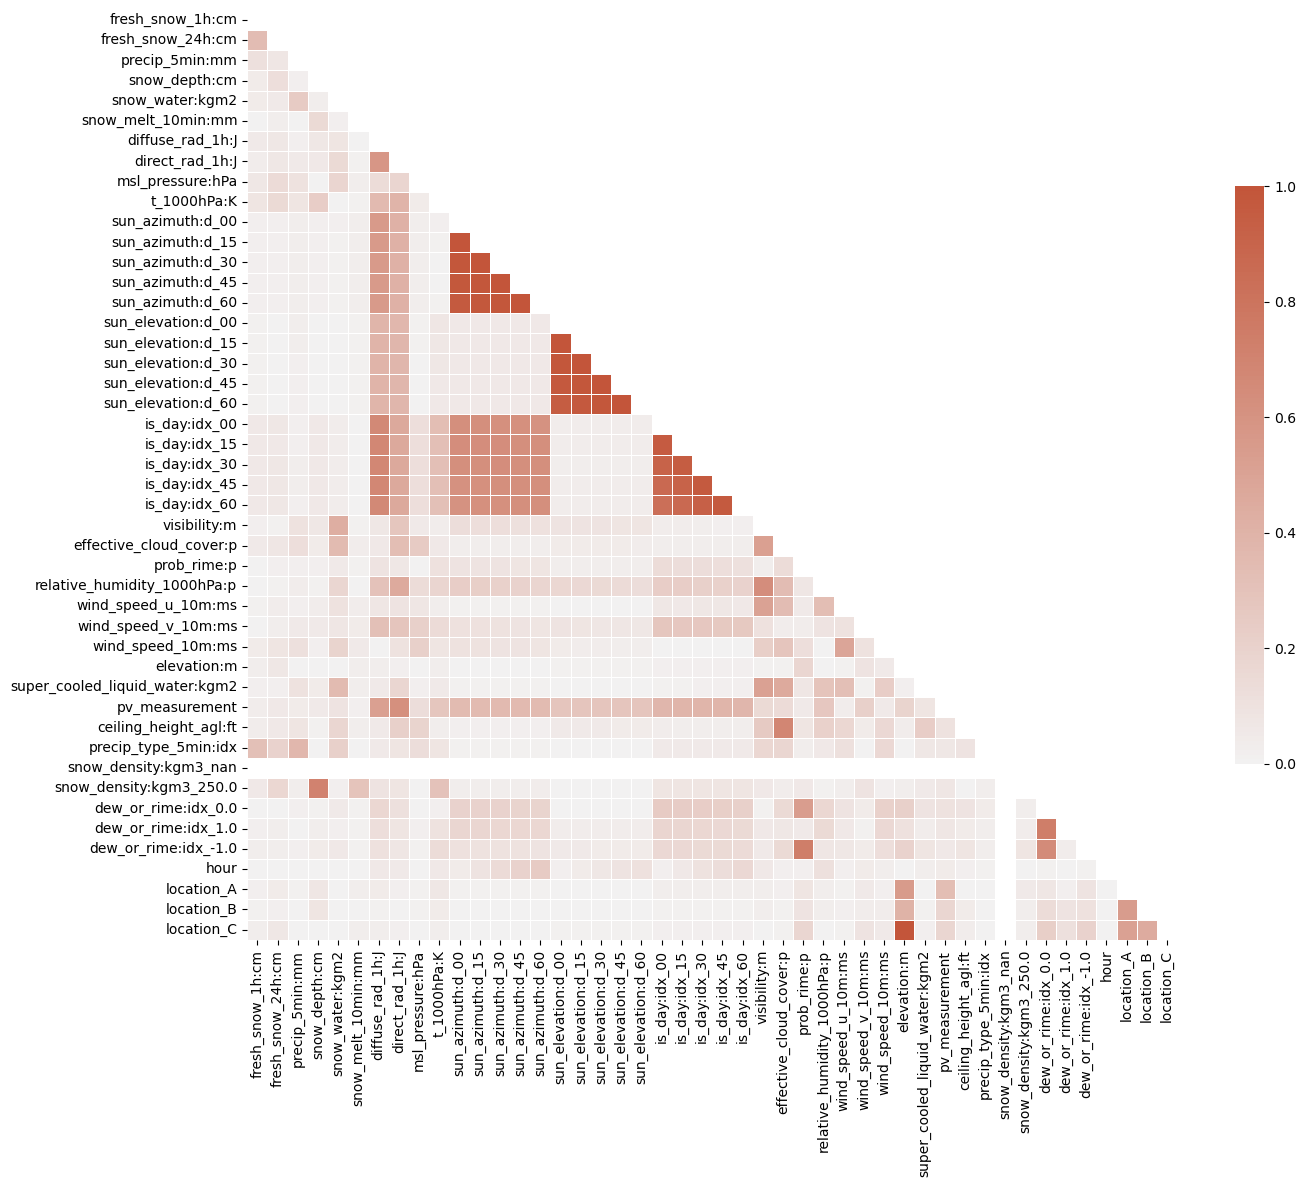

In [138]:
def show_corr_matrix(df):
    corr = df.corr().abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(15, 15))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

show_corr_matrix(dataset.drop(columns=["merge_time", "location", "id"]))

# Split into training set and test set

In [139]:
testset = dataset[dataset["id"].apply(lambda id: id != -10)]
testset = testset.drop(columns=["merge_time", "location", "id", "pv_measurement"])

,fresh_snow_1h:cm,fresh_snow_24h:cm,precip_5min:mm,snow_depth:cm,snow_water:kgm2,snow_melt_10min:mm,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,visibility:m,effective_cloud_cover:p,prob_rime:p,relative_humidity_1000hPa:p,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_10m:ms,elevation:m,super_cooled_liquid_water:kgm2,merge_time,pv_measurement,location,id,ceiling_height_agl:ft,precip_type_5min:idx,snow_density:kgm3_nan,snow_density:kgm3_250.0,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,hour,location_A,location_B,location_C
88802,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.659926,-0.451228,0.310667,-0.865352,1.431783,1.411845,1.386290,1.355330,1.318471,0.689837,0.702108,0.717369,0.735052,0.754535,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-0.192475,0.174714,-0.143281,0.471260,0.516644,1.424807,0.527130,-0.702442,-0.537165,2023-05-01 00:00:00,0.0,A,0,2,0.0,0,0,1,0,0,0,1,0,0
88803,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.659926,-0.451228,0.272483,-0.865352,1.318641,1.277418,1.231623,1.181584,1.126915,0.754630,0.775329,0.796378,0.817011,0.836241,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-0.210404,0.407577,-0.143281,0.432047,0.451960,1.392716,0.446737,-0.702442,-0.537165,2023-05-01 01:00:00,0.0,A,1,3,0.0,0,0,1,0,0,1,1,0,0
88804,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.659926,-0.451228,0.235828,-0.856202,1.127087,1.069243,1.008098,0.943906,0.876391,0.836333,0.853519,0.867673,0.877950,0.883391,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-0.095699,0.542055,-0.143281,0.285001,0.387276,1.349928,0.354859,-0.702442,-0.537165,2023-05-01 02:00:00,0.0,A,2,3,0.0,0,0,1,0,0,2,1,0,0
88805,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.400656,-0.402890,0.196116,-0.850108,0.876567,0.806954,0.735095,0.661183,0.584954,0.883481,0.883545,0.877384,0.864323,0.843681,-0.972627,1.028121,1.029525,1.028166,1.028370,0.087999,-0.007501,-0.143281,0.137954,0.279469,1.317838,0.262981,-0.702442,-0.537165,2023-05-01 03:00:00,0.0,A,3,3,0.0,0,0,1,0,0,3,1,0,0
88806,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,0.212288,-0.146474,0.164043,-0.844010,0.585133,0.507574,0.428518,0.348075,0.266048,0.843772,0.815240,0.778347,0.732702,0.678137,1.028144,1.028121,1.029525,1.028166,1.028370,0.116227,0.057700,-0.143281,0.030119,0.236346,1.264353,0.171104,-0.702442,-0.537165,2023-05-01 04:00:00,0.0,A,4,3,0.0,0,0,1,0,0,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90957,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.156375,-0.353790,-1.322060,1.116163,0.770390,0.838259,0.903788,0.966822,1.026524,0.723053,0.764359,0.798352,0.825613,0.846625,1.028144,1.028121,1.029525,1.028166,1.028370,0.424909,0.582224,-0.143281,-0.107125,0.451960,-0.917814,-0.495010,1.545583,0.230662,2023-07-03 19:00:00,0.0,C,2155,4,0.0,0,0,1,0,0,19,0,0,1
90958,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.455996,-0.425135,-1.291516,1.052147,1.026698,1.083890,1.137963,1.188668,1.235069,0.846716,0.862370,0.873246,0.880049,0.883367,1.028144,1.028121,1.029525,1.028166,1.028370,0.473844,0.272517,-0.143281,0.170164,0.502270,-0.864330,-0.449071,1.545583,-0.537165,2023-07-03 20:00:00,0.0,C,2156,3,0.0,0,0,1,0,0,20,0,0,1
90959,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.618825,-0.451228,-1.262496,0.975935,1.235240,1.278246,1.317180,1.351813,1.381161,0.883457,0.884221,0.882988,0.880391,0.876903,1.028144,-0.972648,-0.971322,-0.972605,-0.972413,0.441888,0.488497,-0.143281,0.527278,0.487896,-0.853633,-0.472040,1.545583,-0.5

In [140]:
dataset = dataset[dataset["id"].apply(lambda id: id == -10)]
dataset = dataset.drop("id", axis=1)

dataset = dataset.sort_values(by="merge_time")

datasetX = dataset.drop(columns=["pv_measurement", "merge_time", "location"])
datasetY = dataset['pv_measurement']

display(datasetX)
display(datasetY)
display(testset)

,fresh_snow_1h:cm,fresh_snow_24h:cm,precip_5min:mm,snow_depth:cm,snow_water:kgm2,snow_melt_10min:mm,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,visibility:m,effective_cloud_cover:p,prob_rime:p,relative_humidity_1000hPa:p,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_10m:ms,elevation:m,super_cooled_liquid_water:kgm2,ceiling_height_agl:ft,precip_type_5min:idx,snow_density:kgm3_nan,snow_density:kgm3_250.0,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,hour,location_A,location_B,location_C
34059,-0.086342,-0.189994,0.244911,-0.155195,-0.124036,-0.064911,-0.659926,-0.451228,-1.731391,-0.194681,1.419053,1.383525,1.337495,1.282086,1.217849,-2.654953,-2.594315,-2.514920,-2.418470,-2.305344,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-0.967130,0.530412,-0.143281,1.087457,0.200410,1.061112,-0.058591,-0.577551,-0.537165,4,1.0,0,0,1,0,0,0,0,1,0
34060,-0.086342,-0.189994,1.418789,-0.155195,0.045828,-0.064911,-0.659926,-0.451228,-1.789431,-0.209925,1.218020,1.147431,1.071282,0.990715,0.906188,-2.305119,-2.179240,-2.042041,-1.895421,-1.740498,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-1.148899,0.884364,-0.143281,1.031439,0.351340,1.360625,0.331890,-0.577551,-0.537165,4,0.0,0,0,1,0,0,1,0,1,0
34061,-0.086342,-0.189994,-0.206581,-0.155195,0.045828,-0.064911,-0.659926,-0.451228,-1.798595,-0.225168,0.906363,0.819816,0.731630,0.642435,0.552303,-1.740298,-1.580746,-1.417812,-1.253370,-1.088247,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-1.271461,0.865153,-0.143281,0.957215,0.559767,1.488988,0.607522,-0.577551,0.614575,4,0.0,0,0,1,0,0,2,0,1,0
34062,-0.086342,-0.189994,0.335209,-0.155195,0.045828,-0.064911,-0.659926,-0.451228,-1.774157,-0.298329,0.552482,0.462675,0.373178,0.284282,0.195837,-1.088074,-0.925087,-0.765216,-0.609550,-0.458891,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-1.514489,0.875049,-0.143281,1.077654,1.113177,1.478291,1.193243,-0.577551,1.382402,4,1.0,0,0,1,0,0,3,0,1,0
34063,-0.086342,-0.189994,-0.206581,-0.155195,0.045828,-0.064911,-0.659926,-0.451228,-1.731387,-0.255655,0.196021,0.108788,0.022680,-0.062253,-0.146110,-0.458745,-0.314637,-0.177778,-0.048653,0.072426,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-1.524916,0.861078,-0.143281,1.248508,1.817517,0.622539,1.755994,-0.577551,0.998489,4,0.0,0,0,1,0,0,4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34057,-0.086342,-0.189994,-0.206581,-0.155195,-0.208968,-0.064911,-0.659926,-0.451228,0.370235,-0.789140,1.383927,1.410137,1.430719,1.445489,1.453527,0.708597,0.692696,0.679817,0.670420,0.664770,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-1.118955,0.912890,-0.143281,0.397036,0.883189,0.986234,0.573069,-0.702442,0.422618,3,0.0,0,0,1,0,0,22,1,0,0
88800,-0.086342,-0.189994,-0.206581,-0.155195,-0.039104,-0.064911,-0.659926,-0.451228,0.377870,-0.804378,1.383888,1.410105,1.430695,1.445477,1.453521,0.707409,0.691421,0.678465,0.669037,0.663333,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-1.222594,0.926861,-0.143281,0.425045,0.574141,0.857871,0.090711,1.545583,0.806532,3,0.0,0,0,1,0,0,22,0,0,1
34058,-0.086342,-0.189994,1.147894,-0.155195,-0.208968,-0.064911,-0.659926,-0.451228,0.342744,-0.813528,1.453695,1.456226,1.452714,1.443187,1.431614,0.664869,0.663239,0.665582,0.671907,0.689739,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-0.993928,0.815669,-0.143281,0.448853,0.710697,1.093203,0.446737,-0.702442,0.038705,3,0.0,0,0,1,0,0,23,1,0,0
62731,-0.086342,-0.189994,-0.206581,-0.155195,-0.208968,-0.064911,-0.659926,-0.451228,0.347321,-0.810477,1.453697,1.456226,1.452714,1.443187,1.431610,0.664869,0.663239,0.665619,0.671907,

34059    0.0
34060    0.0
34061    0.0
34062    0.0
34063    0.0
        ... 
34057    0.0
88800   -0.0
34058    0.0
62731   -0.0
88801   -0.0
Name: pv_measurement, Length: 88802, dtype: float64

,fresh_snow_1h:cm,fresh_snow_24h:cm,precip_5min:mm,snow_depth:cm,snow_water:kgm2,snow_melt_10min:mm,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,visibility:m,effective_cloud_cover:p,prob_rime:p,relative_humidity_1000hPa:p,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_10m:ms,elevation:m,super_cooled_liquid_water:kgm2,merge_time,pv_measurement,location,id,ceiling_height_agl:ft,precip_type_5min:idx,snow_density:kgm3_nan,snow_density:kgm3_250.0,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,hour,location_A,location_B,location_C
88802,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.659926,-0.451228,0.310667,-0.865352,1.431783,1.411845,1.386290,1.355330,1.318471,0.689837,0.702108,0.717369,0.735052,0.754535,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-0.192475,0.174714,-0.143281,0.471260,0.516644,1.424807,0.527130,-0.702442,-0.537165,2023-05-01 00:00:00,0.0,A,0,2,0.0,0,0,1,0,0,0,1,0,0
88803,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.659926,-0.451228,0.272483,-0.865352,1.318641,1.277418,1.231623,1.181584,1.126915,0.754630,0.775329,0.796378,0.817011,0.836241,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-0.210404,0.407577,-0.143281,0.432047,0.451960,1.392716,0.446737,-0.702442,-0.537165,2023-05-01 01:00:00,0.0,A,1,3,0.0,0,0,1,0,0,1,1,0,0
88804,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.659926,-0.451228,0.235828,-0.856202,1.127087,1.069243,1.008098,0.943906,0.876391,0.836333,0.853519,0.867673,0.877950,0.883391,-0.972627,-0.972648,-0.971322,-0.972605,-0.972413,-0.095699,0.542055,-0.143281,0.285001,0.387276,1.349928,0.354859,-0.702442,-0.537165,2023-05-01 02:00:00,0.0,A,2,3,0.0,0,0,1,0,0,2,1,0,0
88805,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.400656,-0.402890,0.196116,-0.850108,0.876567,0.806954,0.735095,0.661183,0.584954,0.883481,0.883545,0.877384,0.864323,0.843681,-0.972627,1.028121,1.029525,1.028166,1.028370,0.087999,-0.007501,-0.143281,0.137954,0.279469,1.317838,0.262981,-0.702442,-0.537165,2023-05-01 03:00:00,0.0,A,3,3,0.0,0,0,1,0,0,3,1,0,0
88806,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,0.212288,-0.146474,0.164043,-0.844010,0.585133,0.507574,0.428518,0.348075,0.266048,0.843772,0.815240,0.778347,0.732702,0.678137,1.028144,1.028121,1.029525,1.028166,1.028370,0.116227,0.057700,-0.143281,0.030119,0.236346,1.264353,0.171104,-0.702442,-0.537165,2023-05-01 04:00:00,0.0,A,4,3,0.0,0,0,1,0,0,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90957,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.156375,-0.353790,-1.322060,1.116163,0.770390,0.838259,0.903788,0.966822,1.026524,0.723053,0.764359,0.798352,0.825613,0.846625,1.028144,1.028121,1.029525,1.028166,1.028370,0.424909,0.582224,-0.143281,-0.107125,0.451960,-0.917814,-0.495010,1.545583,0.230662,2023-07-03 19:00:00,0.0,C,2155,4,0.0,0,0,1,0,0,19,0,0,1
90958,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.455996,-0.425135,-1.291516,1.052147,1.026698,1.083890,1.137963,1.188668,1.235069,0.846716,0.862370,0.873246,0.880049,0.883367,1.028144,1.028121,1.029525,1.028166,1.028370,0.473844,0.272517,-0.143281,0.170164,0.502270,-0.864330,-0.449071,1.545583,-0.537165,2023-07-03 20:00:00,0.0,C,2156,3,0.0,0,0,1,0,0,20,0,0,1
90959,-0.086342,-0.189994,-0.206581,-0.155195,-0.378832,-0.064911,-0.618825,-0.451228,-1.262496,0.975935,1.235240,1.278246,1.317180,1.351813,1.381161,0.883457,0.884221,0.882988,0.880391,0.876903,1.028144,-0.972648,-0.971322,-0.972605,-0.972413,0.441888,0.488497,-0.143281,0.527278,0.487896,-0.853633,-0.472040,1.545583,-0.5

In [ ]:
#!ReWrite
def evaluate_models(models, X, Y):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)


    preds = preds.iloc[:,1:]


    preds["final"] = preds.mean(axis=1)
    preds["losses"] = (preds["final"] - Y).apply(lambda a : np.abs(a))
    return preds["losses"].mean()

In [ ]:
def get_predictions(models, X):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X, verbose=0)


    preds = preds.iloc[:,1:]
    return preds.mean(axis=1)

In [ ]:
num_folds = 9

losses = []
models = []
for f in range(0, num_folds):
  evalIndex=f*10000
  evalSize=10000

  #partition into training and evalset
  trainsetX = pd.concat([datasetX.iloc[:evalIndex,:],datasetX.iloc[evalIndex+evalSize:,:]])
  trainsetY = pd.concat([datasetY.iloc[:evalIndex],datasetY.iloc[evalIndex+evalSize:]])
  evalsetX = datasetX.iloc[evalIndex:evalIndex+evalSize,:]
  evalsetY = datasetY.iloc[evalIndex:evalIndex+evalSize]

  numModels = 20

  models = []



  i = 0
  while(i < numModels):
    if(i < 10):
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(70, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(70, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
        ]))
    else:
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(100, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(80, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(60, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(40, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(20, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
        ]))
    models[i].compile(
        optimizer=tf.keras.optimizers.legacy.Adadelta(learning_rate=1,
                                                            #weight_decay=0.0001
                                                            ),
        loss="mean_absolute_error"
    )

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        y = trainsetY.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        batch_size = 1000,
                        epochs = 1,
                        verbose = 0,
                        #validation_data = [evalsetX, evalsetY]
                    )

    #retry if model is nonsensical
    loss = models[i].evaluate(evalsetX, evalsetY, verbose=0)
    if(loss < evalsetY.mean() + 4 and loss > evalsetY.mean() - 4):
      print("discarding")
      del models[i]
      continue

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.65 if i < 10 else 0.65, random_state=i),
                        y = trainsetY.sample(frac=0.65 if i < 10 else 0.65, random_state=i),
                        batch_size = 1000,
                        epochs = 40,
                        verbose = 0,
                        validation_data = [evalsetX, evalsetY]
                    )
    loss = models[i].evaluate(evalsetX, evalsetY)
    print(i, " complete")
    i+=1

  loss = evaluate_models(models, evalsetX, evalsetY)
  print(loss)
  losses.append(loss)

print(losses)


In [ ]:
evalsetX.iloc[:,1:2]
evalsetX.head()

In [ ]:
preds = get_predictions(models, evalsetX)

In [ ]:
comparison = dataset[["location", "merge_time", "pv_measurement"]]
comparison = comparison.iloc[20000:30000,:]
comparison["pv_pred"] = preds
comparison = comparison.rename(columns={"pv_measurement": "pv_true"})

comparisonA = comparison[comparison["location"].apply(lambda loc: loc == "A")]
comparisonB = comparison[comparison["location"].apply(lambda loc: loc == "B")]
comparisonC = comparison[comparison["location"].apply(lambda loc: loc == "C")]

display(comparison.describe())

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20), sharex=True)

comparisonA.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[0], title='A', color='blue')
comparisonA.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[0], title='A', color='red')
comparisonB.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[1], title='B', color='blue')
comparisonB.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[1], title='B', color='red')
comparisonC.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[2], title='C', color='blue')
comparisonC.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[2], title='C', color='red')